In another Jupyter notebook I trained a resnet50 convnet to classify microscope images into one of five classes. Validation loss over training suggests the model learned a little, but is still not very accurate. In this Notebook I compare some predictions to images to see how well the model is working at this stage.

The code to do this comparison comes from the Pytorch 60 minute blitz tutorial:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [39]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np

In [40]:
# Define a function to display images
%matplotlib inline
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize (may need to fix this for current image set)
    # Normalize to z score: z = (X - mu) / sigma
    # De-normalize: (z * simga) + mu = X
    img = img * 0.229 + 0.485 # Values from normalize in the next cell
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Load up images using torch and torch vision

In [41]:
data_dir = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/microscope_images/test'

data_dir = 'microscope_images'
# Make sure you are running the code from the folder that contains data_dir, or it won't work
num_train = 10
num_test = 10

# Define transforms for the training data and testing data
resnet_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


# Load the images from the image folder
testdata = datasets.ImageFolder(data_dir + '/test', transform=resnet_transforms)


# Load from the training and test sets
testloader = torch.utils.data.DataLoader(testdata, batch_size=num_train, shuffle=True)

class_names = testdata.classes
print('Detected ' + str(len(class_names)) + ' classes in test data')
print(class_names)

Detected 5 classes in test data
['acceptable', 'slightly_out_neg', 'slightly_out_pos', 'very_out_neg', 'very_out_pos']


Now that images are loaded up in torch data structures torch functions can be used to sample a set of images

Currently, these images look TERRIBLE. I am not sure how much of this is what is actually being passed into the model, or if it is because I'm modifying code that was meant to work with a different normalization scheme and I need to do a better job of de-normalizing to get the images to look like themselves.

Load the model so it is available for testing

In [42]:
%%capture # Keeps notebook from printing the entire model
# Load resnet50
#model = models.resnet50(pretrained=True)

# Get the state dict for the model that was trained
model_path = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/autofocus_resnet.pth'
model = torch.load(model_path)
model.eval()

UsageError: unrecognized arguments: Keeps notebook from printing the entire model


In [49]:
# Load a set of images from the testloader
dataiter = iter(testloader)
images, labels = dataiter.next()
print(labels)

# Get the model predictions for the images
outputs = model(images)

# Get the value and index of the highest number for each image output
predicted = torch.max(outputs, 1)
print(predicted)

tensor([1, 2, 4, 2, 4, 3, 1, 0, 4, 4])
torch.return_types.max(
values=tensor([-1.1049, -0.9757, -1.1049, -1.1014, -1.0607, -0.7338, -0.9853, -0.8844,
        -0.9328, -1.0566], grad_fn=<MaxBackward0>),
indices=tensor([3, 4, 3, 4, 3, 3, 3, 3, 3, 4]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


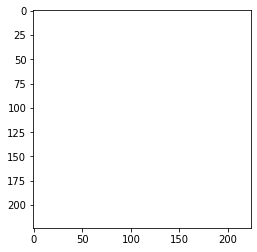

GroundTruth: slightly_out_neg
Prediction: very_out_neg


In [50]:
# Print selected images, and their predicted class
# print the images, their known labels, and the prediction
imshow(images[0])
print('GroundTruth: ' + class_names[labels[0]])
print('Prediction: ' + class_names[predicted.indices[0]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


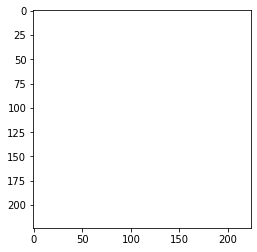

GroundTruth: very_out_pos
Prediction: very_out_neg


In [51]:
# Print selected images, and their predicted class
# print the images, their known labels, and the prediction
imshow(images[2])
print('GroundTruth: ' + class_names[labels[2]])
print('Prediction: ' + class_names[predicted.indices[2]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


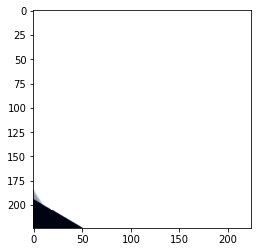

GroundTruth: very_out_pos
Prediction: very_out_neg


In [52]:
# Print selected images, and their predicted class
# print the images, their known labels, and the prediction
imshow(images[4])
print('GroundTruth: ' + class_names[labels[4]])
print('Prediction: ' + class_names[predicted.indices[4]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


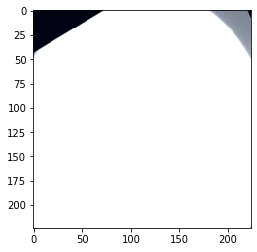

GroundTruth: slightly_out_neg
Prediction: very_out_neg


In [53]:
# Print selected images, and their predicted class
# print the images, their known labels, and the prediction
imshow(images[6])
print('GroundTruth: ' + class_names[labels[6]])
print('Prediction: ' + class_names[predicted.indices[6]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


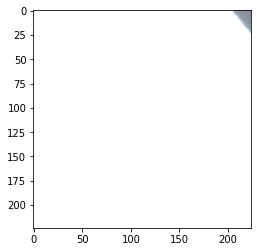

GroundTruth: acceptable
Prediction: very_out_neg


In [56]:
# Print selected images, and their predicted class
# print the images, their known labels, and the prediction
imshow(images[7])
print('GroundTruth: ' + class_names[labels[7]])
print('Prediction: ' + class_names[predicted.indices[7]])

This last prediction is very off. Some of the others might be arguable cases - very out positive and negative may not look all that different. But mistaking positive for very out is clearly wrong.

In [58]:
# Evaluate on all images in the test loader
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on ' + str(total) + ' test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on 900 test images: 34 %


The accuracy of choosing based on random chance is 1/5, or 20%. The model is doing better than random chance, although not by much.